<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/weights/DUDL_weights_freezeWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [6]:
def create_the_MNIST_net():
    """"
    FFN_WEIGHTHISTOGRAMS | MODEL_PERFORM_APRF_WINE | WEIGHTS_FREEZE_WEIGHTS
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, loss_func, optimizer


# Brief inspection of requires_grad

In [7]:
# Inspect the "learning toggle" of a layer
N = create_the_MNIST_net()[0]
N.fc1.weight.requires_grad

True

In [8]:
N = create_the_MNIST_net()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False
  

# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


In [9]:
N = create_the_MNIST_net()[0]

# sSwitch off all layers except input
for p in N.named_parameters():
    if ('input' not in p[0]):
        p[1].requires_grad = False

# Check what we've done
for p in N.named_parameters():
    print(f'Requires_grad status in layer {p[0]}: {p[1].requires_grad}')

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


# Create a function that trains the model

In [10]:
def train_the_model(net, loss_func, optimizer):
    """
    WEIGHTS_FREEZE_WEIGHTS
    """
    
    num_epochs = 100

    # Initialize accuracies as empties
    train_acc = []
    test_acc  = []
    losses = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Switch off learning in all-but-output layers during first 1/2 of training
        if (epoch_i < (num_epochs / 2)):
            for p in net.named_parameters():
                if ('output' not in p[0]):
                    p[1].requires_grad = False
        else:
            for p in net.named_parameters():
                p[1].requires_grad = True
        
        # Activate training mode
        net.train()

        # Loop over training data batches
        batch_acc = []
        batch_loss = []

        for X, y in train_loader:

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy just for this batch
            batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

            # Loss from this batch
            batch_loss.append(loss.item())

        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy 
        train_acc.append(np.mean(batch_acc))

        # Get average losses across the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy (NOTE: testing in batches!)    
        X, y = next(iter(test_loader))  # Extract x,y from test dataloader
        net.eval()                 # Activate testing mode
        with torch.no_grad():           # Deactivates autograd
            # pred_labels = torch.argmax(net(X), axis=1)
            pred_labels = net(X)

        # Compute accuracy
        test_acc.append(100 * torch.mean(((torch.argmax(pred_labels, axis=1)) == y).float()))

    # Function output
    return train_acc, test_acc, losses, net

# Let's see it in action!

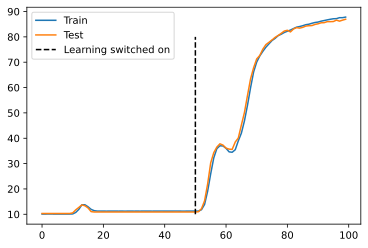

In [13]:
# Create the network
net, loss_func, optimizer = create_the_MNIST_net()

# Train the model
train_acc, test_acc, losses, net = train_the_model(net, loss_func, optimizer)

plt.plot(train_acc, label='Train')
plt.plot(test_acc,  label='Test')
plt.plot([len(train_acc) / 2, len(train_acc) / 2], [10, 80], 'k--', label='Learning switched on')
plt.legend()
plt.show()

# Additional explorations
1) Switch off all the weights, but leave all the biases switched on. Can the model still learn (at least, better than 
   chance level)? Then do the opposite: let the weights learn but turn off learnign in the biases. How does the model
   perform now, and what does this tell you about weights vs. biases?

2) Freeze only one layer, e.g., layer fc1 (freeze both the weights and biases). Store the accuracy output as a separate
   variable, so you run the network again without freezing anything. Then plot the accuracies (with and without 
   freezing) on the same graph. How important is fc1 based on this plot?